In [ ]:
!pip install --upgrade openai-agents

In [ ]:
!pip install -q gradio openai python-dotenv requests httpx pillow

In [ ]:

import os
import requests  
import httpx  
import json  
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image  
from openai import OpenAI  

from PIL import Image
import asyncio, pathlib


load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")



In [ ]:

def print_markdown(text):
    display(Markdown(text))

In [ ]:

MCP_BASE = "http://localhost:7860/gradio_api/mcp/sse"  
from agents.mcp import MCPServerSse


mcp_tool = MCPServerSse({
    "name": "AI Tutor",
    "url": MCP_BASE,
    "timeout": 30,
    "client_session_timeout_seconds":60
})


In [10]:

client = httpx.Client()  


def fetch_schema(server_url):
    """Fetches and parses the MCP schema from a server."""
    
    schema_url = server_url.replace("/sse", "/schema")
    print(f"Fetching schema from: {schema_url}")
    
    response = client.get(schema_url, timeout = 10)  
    response.raise_for_status()  
    schema_data = response.json()
    print("Schema fetched successfully!")
    return schema_data


In [11]:

print("--- Fetching AI Tutor Schema ---")
tutor_schema = fetch_schema(MCP_BASE)

if tutor_schema:
    print("\nAI Tutor Schema Contents:")
    print(json.dumps(tutor_schema, indent=2))

print("\n" + "=" * 50 + "\n") 


--- Fetching AI Tutor Schema ---
Fetching schema from: http://localhost:7860/gradio_api/mcp/schema
Schema fetched successfully!

AI Tutor Schema Contents:
{
  "explain_concept": {
    "type": "object",
    "properties": {
      "question": {
        "type": "string"
      },
      "level": {
        "type": "number",
        "description": "numeric value between 1 and 5"
      }
    },
    "description": "Stream an explanation of *question* at the requested *level* (1\u20115). If 1, explanation would be like we are talking to a 5 year old and if 5, explanation would be technical and complex."
  },
  "summarize_text": {
    "type": "object",
    "properties": {
      "text": {
        "type": "string"
      },
      "compression_ratio": {
        "type": "number",
        "description": "numeric value between 0.1 and 0.8"
      }
    },
    "description": "Stream a summary of *text* compressed to roughly *compression_ratio* length. *compression_ratio* should be between 0.1 and 0.8."
  }

In [12]:

from agents import Agent, Runner

agent = Agent(
    name = "Smart Assistant",
    instructions = """
    Context
    -------
    You are an AI assistant with access to an MCP server exposing **four streaming tools**:

    1. **explain_concept**  
    Arguments: { "question": <str>, "level": <int 1‑5> }  
    • Streams an explanation of any concept at the requested depth.

    2. **summarize_text**  
    Arguments: { "text": <str>, "compression_ratio": <float 0.1‑0.8> }  
    • Streams a concise summary ~compression_ratio × original length.

    3. **generate_flashcards**  
    Arguments: { "topic": <str>, "num_cards": <int 1‑20> }  
    • Streams JSON‑lines flashcards: one card per line `{ "q":…, "a":… }`.

    4. **quiz_me**  
    Arguments: { "topic": <str>, "level": <int 1‑5>, "num_questions": <int 1‑15> }  
    • Streams an MC‑question quiz, then an ANSWER KEY section.

    Objective
    ---------
    Help users learn by:
    • Explaining concepts at the depth they request.  
    • Summarising long passages.  
    • Generating flashcards for self‑study.  
    • Quizzing them interactively.

    How to respond
    --------------
    • For each user request, decide which tool (if any) fulfils it best.  
    • Call the tool via MCP by returning *only* the JSON with `"tool"` and `"arguments"` (no extra text).  
    • If a follow‑up conversation is needed (e.g., clarification), ask the user first.  
    • If no tool fits, answer directly in plain language.

    Examples
    --------
    User: “Explain quantum tunnelling like I’m 10.”  
    → Call `explain_concept` with { "question": "quantum tunnelling", "level": 2 }

    User: “Summarise this article to 20 %.” + <article text>  
    → Call `summarize_text` with { "text": "...", "compression_ratio": 0.2 }

    Chat capability
    ---------------
    After each tool call completes (streaming back to the user), remain in the chat loop ready for the next user turn.
    """,
    model = "gpt-4o-mini",
    mcp_servers = [mcp_tool],
)

In [13]:
await mcp_tool.connect()  # open SSE channels

result = None
while True:
    user_input = input("User: ")
    if user_input.lower() in {"exit", "quit"}:
        break
        
    if result is not None:
        new_input = result.to_input_list() + [{"role": "user", "content": user_input}]
    else:
        new_input = [{"role": "user", "content": user_input}]
    print("\nUser Input:")
    print_markdown(user_input)



    result = await Runner.run(starting_agent = agent, input = new_input)
    print("\nAssistant:")
    print_markdown(result.final_output)

User:  explain how iphone works in a simple term 



User Input:


explain how iphone works in a simple term 


Assistant:


The iPhone is like a tiny computer in your pocket. It has a screen, buttons, and a battery. You can touch the screen to open apps, talk to your friends, take pictures, and play games. It connects to the internet to help you find information and share things. Inside, it has parts that help it think (like a brain) and parts that help it remember things (like memory).

User:  generate a list of 10 questions as part of a quiz



User Input:


generate a list of 10 questions as part of a quiz


Assistant:


Here are 10 questions for the quiz on iPhones:

1. What is the name of the app store on iPhones?
2. What is the main button on the front of the iPhone called?
3. Which company makes the iPhone?
4. What do you use to unlock an iPhone?
5. What can you do with the camera on an iPhone?
6. What is Siri?
7. How can you charge an iPhone?
8. What does Wi-Fi do for your iPhone?
9. What is the iPhone's operating system called?
10. What feature allows you to talk to someone using voice commands?

Would you like to see the answers to these questions?

User:  exit


In [14]:

for i in result.to_input_list():
    for key in i.keys():
        if key == 'arguments':
            print("Tool: ", i['name'])
            print("Arguments: ", i['arguments'])


Tool:  explain_concept
Arguments:  {"question":"how iPhone works","level":2}
Tool:  explain_concept
Arguments:  {"question":"how iPhone works","level":1}
Tool:  quiz_me
Arguments:  {"topic":"iPhone","level":1,"num_questions":10}


In [ ]:
def explain_concept_in_language(question: str, level: int, language: str) -> Generator[str, None, None]:
    """Stream an explanation of *question* at the requested *level* (1‑5) in the specified *language*. 
    Need: question, level, language"""

    if not question.strip():
        yield "Error: question cannot be blank."
        return

    level_desc = EXPLANATION_LEVELS.get(level, "clearly and concisely")
    system_prompt = "You are a helpful AI Tutor. Explain the following concept " f"{level_desc} in the following language: {language}"
    _stream = client.chat.completions.create(
        model = MODEL_NAME,
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question},
        ],
        stream = True,
        temperature =0.7,
    ) 
    partial = ""
    for chunk in _stream:
        delta = getattr(chunk.choices[0].delta, "content", None)
        if delta:
            partial += delta
            yield partial


In [ ]:


def build_demo():
    with gr.Blocks() as demo:
        gr.Markdown("# AI Tutor MCP Toolkit – Demo Console")
        with gr.Tab("Explain Concept"):
            q = gr.Textbox(label = "Concept / Question")
            lvl = gr.Slider(1, 5, value = 3, step = 1, label = "Explanation Level")
            out1 = gr.Markdown()
            gr.Button("Explain").click(explain_concept, inputs = [q, lvl], outputs = out1)
        with gr.Tab("Explain Concept in Language"):
            q = gr.Textbox(label = "Concept / Question")
            lvl = gr.Slider(1, 5, value = 3, step = 1, label = "Explanation Level")
            lang = gr.Textbox(label = "Language")
            out2 = gr.Markdown()
            gr.Button("Explain").click(explain_concept_in_language, inputs = [q, lvl, lang], outputs = out2)
        with gr.Tab("Summarize Text"):
            txt = gr.Textbox(lines = 8, label = "Long Text")
            ratio = gr.Slider(0.1, 0.8, value = 0.3, step = 0.05, label = "Compression Ratio")
            out3 = gr.Markdown()
            gr.Button("Summarize").click(summarize_text, inputs=[txt, ratio], outputs = out3)
        with gr.Tab("Flashcards"):
            topic_fc = gr.Textbox(label = "Topic")
            n_fc = gr.Slider(1, 20, value = 5, step = 1, label = "# Cards")
            out4 = gr.Markdown()
            gr.Button("Generate").click(generate_flashcards, inputs = [topic_fc, n_fc], outputs = out4)
        with gr.Tab("Quiz Me"):
            topic_q = gr.Textbox(label = "Topic")
            lvl_q = gr.Slider(1, 5, value = 3, step = 1, label = "Difficulty Level")
            n_q = gr.Slider(1, 15, value = 5, step = 1, label = "# Questions")
            out5 = gr.Markdown()
            gr.Button("Start Quiz").click(quiz_me, inputs = [topic_q, lvl_q, n_q], outputs = out5)
    return demo


if __name__ == "__main__":
    print("Starting AI Tutor MCP Toolkit on port 7860…")
    build_demo().launch(server_name = "0.0.0.0", mcp_server = True)



In [ ]:


def explain_concept(question: str, level: int) -> Generator[str, None, None]:
    """Stream an explanation of *question* at the requested *level* (1‑5). If 1, explanation would be like we are talking to a 5 year old and if 5, explanation would be technical and complex."""
    if not question.strip():
        yield "Error: question cannot be blank."
        return

    level_desc = EXPLANATION_LEVELS.get(level, "clearly and concisely")
    system_prompt = "You are a helpful AI Tutor. Explain the following concept " f"{level_desc}."
    _stream = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question},
        ],
        stream=True,
        temperature=0.7,
    )
    partial = ""
    for chunk in _stream:
        delta = getattr(chunk.choices[0].delta, "content", None)
        if delta:
            partial += delta
            yield partial

**Original Schema:**

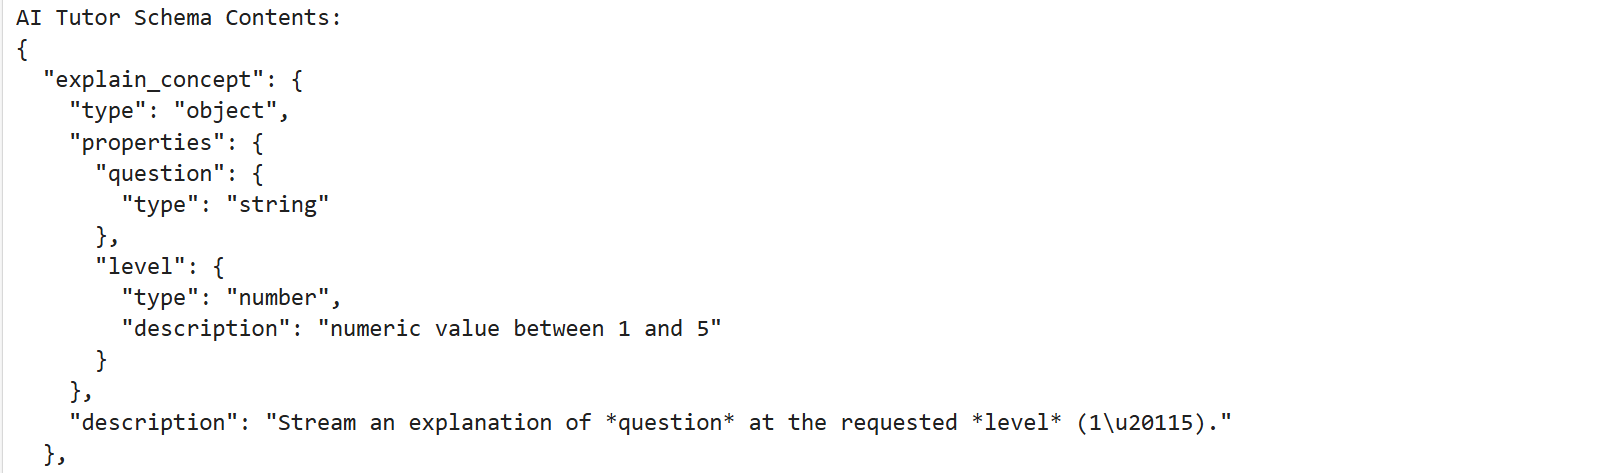

**New Schema:**

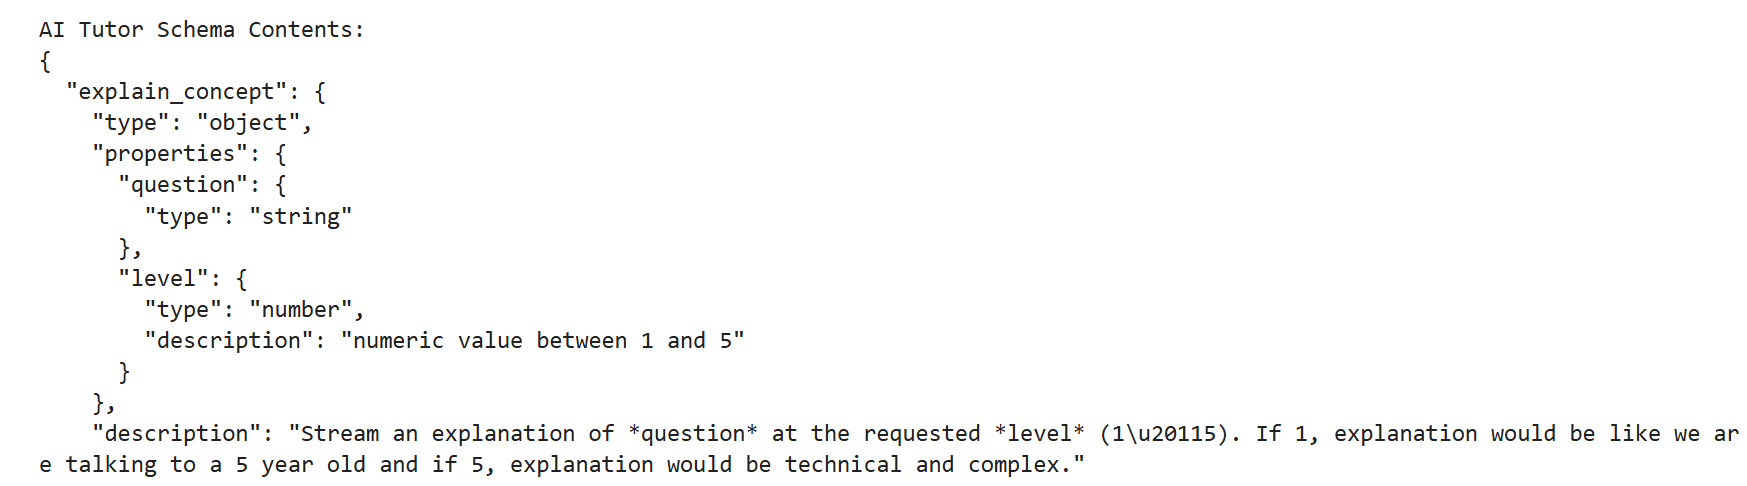